# Import libraries

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import datasets

In [3]:
train = pd.read_excel('/kaggle/input/predict-food-delivery-time/Data_Train.xlsx')
test = pd.read_excel('/kaggle/input/predict-food-delivery-time/Data_Test.xlsx')

In [4]:
train.shape, test.shape

((11094, 9), (2774, 8))

# Data exploration

In [5]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [6]:
train.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99,30,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176,95,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521,235,65 minutes


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 9 columns):
Restaurant       11094 non-null object
Location         11094 non-null object
Cuisines         11094 non-null object
Average_Cost     11094 non-null object
Minimum_Order    11094 non-null object
Rating           11094 non-null object
Votes            11094 non-null object
Reviews          11094 non-null object
Delivery_Time    11094 non-null object
dtypes: object(9)
memory usage: 780.2+ KB


In [8]:
train.nunique()

Restaurant       7480
Location           35
Cuisines         2179
Average_Cost       26
Minimum_Order      18
Rating             33
Votes            1103
Reviews           761
Delivery_Time       7
dtype: int64

In [9]:
train['Delivery_Time'].value_counts()

30 minutes     7406
45 minutes     2665
65 minutes      923
120 minutes      62
20 minutes       20
80 minutes       14
10 minutes        4
Name: Delivery_Time, dtype: int64

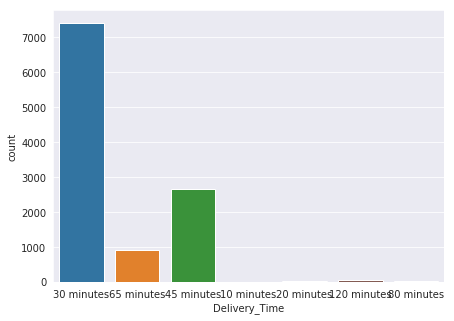

In [10]:
plt.figure(figsize=(7,5))
sns.countplot(x='Delivery_Time', data=train)

# Data pre-processing

In [11]:
train = train[train['Delivery_Time'] != '10 minutes']
train.shape

(11090, 9)

In [12]:
df = train.append(test,ignore_index=True, sort=False)
df.shape

(13864, 9)

In [13]:
df.head(2) 

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes


In [14]:
df['Restaurant'] = df['Restaurant'].astype('category')

In [15]:
df['Cuisines'] = df['Cuisines'].str.replace('Poké','Poke')
df['Cuisines'] = df['Cuisines'].str.replace('Coffee','Tea')
df['Cuisines'] = df['Cuisines'].str.replace('Hyderabadi','Biryani')

cuisines_list = df['Cuisines'].str.split(', ')

from collections import Counter
cuisines_counter = Counter(([a for b in cuisines_list.tolist() for a in b]))

for cuisine in cuisines_counter.keys():
    df[cuisine] = 0
    df.loc[df['Cuisines'].str.contains(cuisine), cuisine] = 1

In [16]:
df['Location'] = df['Location'].str.replace('Sector 63A,Gurgaon', 'Sector 63A, Gurgaon') 
df['Location'] = df['Location'].str.replace('BTM Layout,Bangalore', 'BTM Layout, Bangalore')
df['Location'] = df['Location'].str.replace('Majestic', 'Majestic, Bangalore')

location_list = df['Location'].str.split(', ') 

from collections import Counter
location_counter = Counter(([a for b in location_list.tolist() for a in b]))

for loc in location_counter.keys():
    df[loc] = 0
    df.loc[df['Location'].str.contains(loc), loc] = 1

In [17]:
df['Average_Cost'] = df['Average_Cost'].str.replace('for','-999')
df['Average_Cost'] = df['Average_Cost'].str.replace(',','')
df['Average_Cost'] = df['Average_Cost'].str.replace('₹','').astype(float)
df['Average_Cost'] = df['Average_Cost'].replace('-999',np.NaN) 

In [18]:
df['Minimum_Order'] = df['Minimum_Order'].str.replace('₹','').astype(float)

In [19]:
df['Rating1'] = df['Rating'].str.replace('-','-999')
df['Rating1'] = df['Rating1'].str.replace('NEW','-999')
df['Rating1'] = df['Rating1'].str.replace('Opening Soon','-999')
df['Rating1'] = df['Rating1'].str.replace('Temporarily Closed','-999')
df['Rating1'] = df['Rating1'].astype(float)
df['Rating1'] = df['Rating1'].replace(-999,np.NaN)

agg_func = {
    'Rating1': ['mean','median','min','max','sum']
}
agg_restaurant = df.groupby('Restaurant').agg(agg_func)
agg_restaurant.columns = [ 'Restaurant_' + ('_'.join(col).strip()) for col in agg_restaurant.columns.values]
agg_restaurant.reset_index(inplace=True)
df = df.merge(agg_restaurant, on=['Restaurant'], how='left')

In [20]:
df['Cat_Rating1'] = pd.qcut(df['Rating1'],q=5,labels=False)

In [21]:
df['Rating'] = df['Rating'].astype('category')

In [22]:
df['Votes'] = df['Votes'].str.replace('-','-999')
df['Votes'] = df['Votes'].astype(float)
df['Votes'] = df['Votes'].replace(-999,np.NaN)

In [23]:
df['Reviews'] = df['Reviews'].str.replace('-','-999')
df['Reviews'] = df['Reviews'].astype(float)
df['Reviews'] = df['Reviews'].replace(-999,np.NaN)

In [24]:
calc = df.groupby(['Restaurant'], axis=0).agg({'Restaurant':[('op1', 'count')]}).reset_index() 
calc.columns = ['Restaurant','Restaurant Count']
df = df.merge(calc, on=['Restaurant'], how='left')

In [25]:
agg_func = {
    'Votes': ['mean','median','min','max','sum','std'],
    'Reviews': ['mean','median','min','max','sum','std']
}
agg_restaurant = df.groupby('Restaurant').agg(agg_func)
agg_restaurant.columns = [ 'Restaurant_' + ('_'.join(col).strip()) for col in agg_restaurant.columns.values]
agg_restaurant.reset_index(inplace=True)
df = df.merge(agg_restaurant, on=['Restaurant'], how='left')

In [26]:
df.head(1)

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,Fast Food,Rolls,Burger,Salad,Wraps,Ice Cream,Desserts,Italian,Street Food,Mughlai,North Indian,Chinese,Cafe,Beverages,South Indian,Thai,Asian,Mithai,Momos,Indonesian,Biryani,Kerala,Bihari,Mexican,Japanese,Bakery,Burmese,Bubble Tea,Tea,Pizza,Lucknowi,Mangalorean,European,Continental,Sandwich,Healthy Food,Bengali,American,Mishti,Andhra,Assamese,Maharashtrian,German,Arabian,Finger Food,Kebab,Chettinad,Seafood,Juices,Parsi,Sushi,Odia,Tamil,Cantonese,North Eastern,Tibetan,Lebanese,Spanish,Bar Food,Konkan,Paan,Steak,Mediterranean,Bohri,Afghan,Goan,Gujarati,BBQ,Raw Meats,Malaysian,Vietnamese,Sri Lankan,Rajasthani,Poke,Roast Chicken,Brazilian,Belgian,Naga,Korean,Modern Indian,Awadhi,Kashmiri,French,Portuguese,Charcoal Chicken,Frozen Yogurt,Bangladeshi,Malwani,Iranian,Nepalese,Indian,Tex-Mex,Hot dogs,South American,Middle Eastern,African,Turkish,Israeli,Greek,FTI College,Law College Road,Pune,Sector 3,Marathalli,Mumbai Central,Sector 1,Noida,Rmz Centennial,I Gate,Whitefield,Delhi University-GTB Nagar,Yerawada,Maharashtra,Delhi Administration Flats,Timarpur,Moulali,Kolkata,Dockyard Road,Mumbai CST Area,Pune University,Gora Bazar,Rajbari,North Dumdum,D-Block,Sector 63,Sector 14,Mico Layout,Stage 2,BTM Layout,Bangalore,Laxman Vihar Industrial Area,Sector 3A,Gurgoan,Tiretti,Sandhurst Road,MG Road,Hyderabad Public School,Begumpet,Majestic,Chandni Chowk,Delhi High Court,India Gate,Chatta Bazaar,Malakpet,Hyderabad,Sector 63A,Gurgaon,Delhi Cantt.,Tejas Nagar Colony,Wadala West,Mumbai,Babarpur,New Delhi,Delhi,Nathan Road,Mangaldas Road,Panjetan Colony,Raja Bazar,Jaya Nagar,Saidabad,Noorkhan Bazaar,Musi Nagar,BTM Layout 1,Electronic City,Rating1,Restaurant_Rating1_mean,Restaurant_Rating1_median,Restaurant_Rating1_min,Restaurant_Rating1_max,Restaurant_Rating1_sum,Cat_Rating1,Restaurant Count,Restaurant_Votes_mean,Restaurant_Votes_median,Restaurant_Votes_min,Restaurant_Votes_max,Restaurant_Votes_sum,Restaurant_Votes_std,Restaurant_Reviews_mean,Restaurant_Reviews_median,Restaurant_Reviews_min,Restaurant_Reviews_max,Restaurant_Reviews_sum,Restaurant_Reviews_std
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200.0,50.0,3.5,12.0,4.0,30 minutes,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.5,3.5,3.5,3.5,3.5,3.5,1.0,1,12.0,12.0,12.0,12.0,12.0,NaN,4.0,4.0,4.0,4.0,4.0,NaN


In [27]:
df.drop(['Cuisines','Location','Rating1'], axis=1, inplace=True)

In [28]:
train_df = df[df['Delivery_Time'].isnull()!=True]
test_df = df[df['Delivery_Time'].isnull()==True]
test_df.drop(['Delivery_Time'], axis=1, inplace=True)

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['Delivery_Time'] = le.fit_transform(train_df['Delivery_Time'])
le.classes_

array(['120 minutes', '20 minutes', '30 minutes', '45 minutes',
       '65 minutes', '80 minutes'], dtype=object)

In [30]:
train_df.shape, test_df.shape

((11090, 190), (2774, 189))

In [31]:
train_df.tail(2)

,Restaurant,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,Fast Food,Rolls,Burger,Salad,Wraps,Ice Cream,Desserts,Italian,Street Food,Mughlai,North Indian,Chinese,Cafe,Beverages,South Indian,Thai,Asian,Mithai,Momos,Indonesian,Biryani,Kerala,Bihari,Mexican,Japanese,Bakery,Burmese,Bubble Tea,Tea,Pizza,Lucknowi,Mangalorean,European,Continental,Sandwich,Healthy Food,Bengali,American,Mishti,Andhra,Assamese,Maharashtrian,German,Arabian,Finger Food,Kebab,Chettinad,Seafood,Juices,Parsi,Sushi,Odia,Tamil,Cantonese,North Eastern,Tibetan,Lebanese,Spanish,Bar Food,Konkan,Paan,Steak,Mediterranean,Bohri,Afghan,Goan,Gujarati,BBQ,Raw Meats,Malaysian,Vietnamese,Sri Lankan,Rajasthani,Poke,Roast Chicken,Brazilian,Belgian,Naga,Korean,Modern Indian,Awadhi,Kashmiri,French,Portuguese,Charcoal Chicken,Frozen Yogurt,Bangladeshi,Malwani,Iranian,Nepalese,Indian,Tex-Mex,Hot dogs,South American,Middle Eastern,African,Turkish,Israeli,Greek,FTI College,Law College Road,Pune,Sector 3,Marathalli,Mumbai Central,Sector 1,Noida,Rmz Centennial,I Gate,Whitefield,Delhi University-GTB Nagar,Yerawada,Maharashtra,Delhi Administration Flats,Timarpur,Moulali,Kolkata,Dockyard Road,Mumbai CST Area,Pune University,Gora Bazar,Rajbari,North Dumdum,D-Block,Sector 63,Sector 14,Mico Layout,Stage 2,BTM Layout,Bangalore,Laxman Vihar Industrial Area,Sector 3A,Gurgoan,Tiretti,Sandhurst Road,MG Road,Hyderabad Public School,Begumpet,Majestic,Chandni Chowk,Delhi High Court,India Gate,Chatta Bazaar,Malakpet,Hyderabad,Sector 63A,Gurgaon,Delhi Cantt.,Tejas Nagar Colony,Wadala West,Mumbai,Babarpur,New Delhi,Delhi,Nathan Road,Mangaldas Road,Panjetan Colony,Raja Bazar,Jaya Nagar,Saidabad,Noorkhan Bazaar,Musi Nagar,BTM Layout 1,Electronic City,Restaurant_Rating1_mean,Restaurant_Rating1_median,Restaurant_Rating1_min,Restaurant_Rating1_max,Restaurant_Rating1_sum,Cat_Rating1,Restaurant Count,Restaurant_Votes_mean,Restaurant_Votes_median,Restaurant_Votes_min,Restaurant_Votes_max,Restaurant_Votes_sum,Restaurant_Votes_std,Restaurant_Reviews_mean,Restaurant_Reviews_median,Restaurant_Reviews_min,Restaurant_Reviews_max,Restaurant_Reviews_sum,Restaurant_Reviews_std
11088,ID_4115,100.0,50.0,3.1,24.0,9.0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.1,3.1,3.1,3.1,3.1,0.0,1,24.0,24.0,24.0,24.0,24.0,NaN,9.0,9.0,9.0,9.0,9.0,NaN
11089,ID_4417,100.0,50.0,NEW,NaN,NaN,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN


# Train test split

In [32]:
X = train_df.drop(labels=['Delivery_Time'], axis=1)
y = train_df['Delivery_Time'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [33]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((8317, 189), (8317,), (2773, 189), (2773,))

In [34]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([0, 3])

# Build the model

In [35]:
from math import sqrt 
from sklearn.metrics import accuracy_score

## Catboost

In [36]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=6,
                         random_seed=42, 
                         iterations=1500, 
                         learning_rate=0.06,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200)
cat.fit(X_train, y_train, verbose=50,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)

0:	learn: 0.6924372	test: 0.6924372	test1: 0.7010458	best: 0.7010458 (0)	total: 138ms	remaining: 3m 26s
50:	learn: 0.7683059	test: 0.9452928	test1: 0.8049044	best: 0.8052651 (49)	total: 2.99s	remaining: 1m 24s
100:	learn: 0.7810509	test: 0.9796802	test1: 0.8160837	best: 0.8160837 (91)	total: 5.72s	remaining: 1m 19s
150:	learn: 0.7891066	test: 0.9811230	test1: 0.8204111	best: 0.8211323 (147)	total: 8.72s	remaining: 1m 17s
200:	learn: 0.7982446	test: 0.9819647	test1: 0.8193292	best: 0.8225748 (166)	total: 11.8s	remaining: 1m 16s
250:	learn: 0.8105086	test: 0.9837682	test1: 0.8214930	best: 0.8225748 (166)	total: 14.9s	remaining: 1m 14s
300:	learn: 0.8194060	test: 0.9849705	test1: 0.8225748	best: 0.8229354 (282)	total: 17.9s	remaining: 1m 11s
350:	learn: 0.8274618	test: 0.9856920	test1: 0.8243779	best: 0.8243779 (341)	total: 21s	remaining: 1m 8s
400:	learn: 0.8337141	test: 0.9867741	test1: 0.8258204	best: 0.8258204 (400)	total: 24.1s	remaining: 1m 5s
450:	learn: 0.8402068	test: 0.9877360	t

In [37]:
predictions = cat.predict(X_cv)
print('accuracy:', accuracy_score(y_cv, predictions))

accuracy: 0.8276235124413992


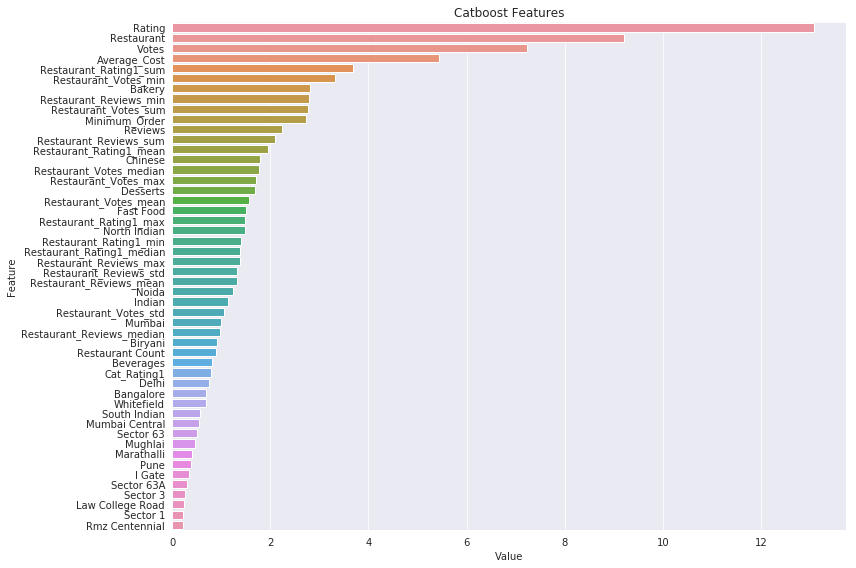

In [38]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

# Predict on test set

In [39]:
Xtest = test_df

## Catboost

In [40]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=6,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.06,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test,y_pred_cat))

    errcat.append(accuracy_score(y_test,y_pred_cat))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

Accuracy:  0.8214607754733995
Accuracy:  0.7944093778178539
Accuracy:  0.8259693417493237
Accuracy:  0.8277727682596934
Accuracy:  0.842200180342651
Accuracy:  0.8259693417493237
Accuracy:  0.8358881875563571
Accuracy:  0.8196573489630298
Accuracy:  0.8412984670874661
Accuracy:  0.8223624887285843


In [41]:
np.mean(errcat,0)

0.8256988277727683

In [42]:
cat_final = np.mean(y_pred_totcat,0).round().astype(int)
cat_final

array([[2],
       [2],
       [2],
       ...,
       [3],
       [2],
       [4]])

# Submission

In [43]:
y_pred_class = le.inverse_transform(cat_final)
df_sub = pd.DataFrame(data=y_pred_class, columns=['Delivery_Time'])
df_sub.head()

,Delivery_Time
0,30 minutes
1,30 minutes
2,30 minutes
3,30 minutes
4,30 minutes


In [44]:
df_sub['Delivery_Time'].value_counts()

30 minutes     2027
45 minutes      625
65 minutes      115
120 minutes       6
80 minutes        1
Name: Delivery_Time, dtype: int64

In [45]:
writer = pd.ExcelWriter('cat44.xlsx', engine='xlsxwriter')
df_sub.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()